In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import gymnasium as gym
import enflow as ef
import treewe as tr

### Load problem

In [2]:
tr.list_problems()

['gefcom2014-wind', 'gefcom2014-solar']

In [3]:
dataset, env, obj = tr.load_problem("gefcom2014-solar")

In [4]:
portfolio = dataset.collection
portfolio.draw_tree(show_type=True)

Portfolio (edm.Portfolio)
├── Site1 (edm.PVSystem)
├── Site2 (edm.PVSystem)
└── Site3 (edm.PVSystem)


In [5]:
env.dataset.data["data_gefcom2014_solar"].head(4)

ZONEID                                      Site1     Site2     Site3  \
                                            Power     Power     Power   
ref_datetime        valid_datetime                                      
2012-04-01 01:00:00 2012-04-01 01:00:00  0.754103  0.647328  0.799000   
                    2012-04-01 02:00:00  0.555000  0.621822  0.817500   
                    2012-04-01 03:00:00  0.438397  0.472692  0.571500   
                    2012-04-01 04:00:00  0.145449  0.098866  0.063775   

ZONEID                                        Site1       Site2       Site3  \
                                             VAR134      VAR134      VAR134   
ref_datetime        valid_datetime                                            
2012-04-01 01:00:00 2012-04-01 01:00:00  94843.6250  94290.6250  92667.6250   
                    2012-04-01 02:00:00  94757.9375  94217.6875  92622.6875   
                    2012-04-01 03:00:00  94732.8125  94201.0625  92598.8125   
                    2012-04-01 04:00:00  94704.0625  94156.0625  92542.0625   

ZONEID                                       Site1      Site2      Site3  \
                                            VAR157     VAR157     VAR157   
ref_datetime        valid_datetime                                         
2012-04-01 01:00:00 2012-04-01 01:00:00  60.221909  57.374252  57.003159   
                    2012-04-01 02:00:00  54.678604  57.129776  64.960831   
                    2012-04-01 03:00:00  61.294891  63.076141  66.795868   
                    2012-04-01 04:00:00  67.775284  62.975479  65.177628   

ZONEID                                      Site1  ...       Site3     Site1  \
                                           VAR164  ...      VAR178    VAR228   
ref_datetime        valid_datetime                 ...                         
2012-04-01 01:00:00 2012-04-01 01:00:00  0.244601  ...   2901861.0  0.000000   
                    2012-04-01 02:00:00  0.457138  ...   5980930.0  0.000000   
                    2012-04-01 03:00:00  0.771429  ...   8822632.0  0.001341   
                    2012-04-01 04:00:00  0.965866  ...  11178847.0  0.002501   

ZONEID                                      Site2     Site3     Site1  \
                                           VAR228    VAR228     VAR78   
ref_datetime        valid_datetime                                      
2012-04-01 01:00:00 2012-04-01 01:00:00  0.000000  0.000000  0.001967   
                    2012-04-01 02:00:00  0.000000  0.000774  0.005524   
                    2012-04-01 03:00:00  0.001256  0.001671  0.030113   
                    2012-04-01 04:00:00  0.001726  0.002084  0.057167   

ZONEID                                      Site2     Site3     Site1  \
                                            VAR78     VAR78     VAR79   
ref_datetime        valid_datetime                                      
2012-04-01 01:00:00 2012-04-01 01:00:00  0.001479  0.003531  0.003609   
                    2012-04-01 02:00:00  0.018304  0.027482  0.033575   
                    2012-04-01 03:00:00  0.035255  0.032356  0.132009   
                    2012-04-01 04:00:00  0.064514  0.031952  0.110645   

ZONEID                                      Site2     Site3  
                                            VAR79     VAR79  
ref_datetime        valid_datetime                           
2012-04-01 01:00:00 2012-04-01 01:00:00  0.005444  0.024673  
                    2012-04-01 02:00:00  0.101553  0.140474  
                    2012-04-01 03:00:00  0.112935  0.136617  
                    2012-04-01 04:00:00  0.107761  0.097370  

[4 rows x 39 columns]

### Create prediction model


In [6]:
        ra =  Ra(longitude=coords[0],
                latitude=coords[1],
                altitude=alt,
                capacity=cap,
                orientation=orien,
                tilt=tilt)

        df_solpos = ra.calculate_solpos(df[str(i+1)].index)
        df_clearsky = ra.calculate_clearsky(df[str(i+1)].index)
        df_power_clearsky = ra.calculate_power_clearsky(df[str(i+1)].index)
        df_weather = ra.weather_from_ghi(df.loc[:,(str(i+1),'VAR169')])
        df_power = ra.calculate_power(df_weather.copy())

        df_solpos = df_solpos.loc[:, ['zenith', 'azimuth']]
        df_clearsky.columns = df_clearsky.columns+'_clearsky'
        df_weather = df_weather.loc[:, ['dni', 'dhi', 'ghi', 'kt']]

NameError: name 'Ra' is not defined

In [6]:
import lightgbm as lgb
import pandas as pd

class LGBGEFCom2014Predictor(ef.Predictor):
    def __init__(self, portfolio: ef.Portfolio, name=None, quantiles=None):
        """
        Initialize the Predictor class.
        
        Args:
            quantiles (list): List of quantiles for which to create separate models.
                              Example: [0.1, 0.5, 0.9]
        """

        self.portfolio = portfolio
        self.name = name
        self.models = {}  # Dictionary to hold models for each site and quantile
        self.quantiles = quantiles
    
    def preprocess(self, df_features: pd.DataFrame) -> pd.DataFrame:
        
        # Reassign df to a copy only within the function scope
        df_features = df_features.copy()

        # Differentiate accumulated features
        features_accum = ['VAR169', 'VAR175', 'VAR178', 'VAR228']
        df_accum = df_features.loc[:,(slice(None),features_accum)]
        df_accum = df_accum.diff()
        df_accum[df_accum.index.get_level_values(1).hour==1] = df_features.loc[df_accum.index.get_level_values(1).hour==1,(slice(None),features_accum)]
        df_accum.loc[:,(slice(None),features_accum[:3])] = df_accum.loc[:,(slice(None),features_accum[:3])]/3600 # Convert from J to Wh/h
        df_features.loc[:,(slice(None),features_accum)] = df_accum 

        # Calculate solar position
        index = df_features.index.get_level_values(1)
        assets = portfolio.assets
        for asset in assets: 
            df_solpos = asset.location.to_pvlib().get_solarposition(index)
            df_solpos = df_solpos.loc[:, ['zenith', 'azimuth']]
            df_solpos.index = df_features.index
            for column in df_solpos.columns: 
                df_features[(asset.name, column)] = df_solpos[column]
#            df_features.loc[:, (asset.name, ['zenith', 'azimuth'])] = df_solpos

        return df_features

        """
        ra =  Ra(longitude=coords[0],
                latitude=coords[1],
                altitude=alt,
                capacity=cap,
                orientation=orien,
                tilt=tilt)

        df_solpos = ra.calculate_solpos(df[str(i+1)].index)
        df_clearsky = ra.calculate_clearsky(df[str(i+1)].index)
        df_power_clearsky = ra.calculate_power_clearsky(df[str(i+1)].index)
        df_weather = ra.weather_from_ghi(df.loc[:,(str(i+1),'VAR169')])
        df_power = ra.calculate_power(df_weather.copy())

        df_solpos = df_solpos.loc[:, ['zenith', 'azimuth']]
        df_clearsky.columns = df_clearsky.columns+'_clearsky'
        df_weather = df_weather.loc[:, ['dni', 'dhi', 'ghi', 'kt']]
        """

    def train(self, df_features: pd.DataFrame, target: pd.DataFrame, **kwargs):
        """
        Train separate LightGBM models for each site and quantile.
        
        Args:
            features (pd.DataFrame): Multi-indexed dataframe where the top-level index corresponds to sites.
            target (pd.DataFrame): The target dataframe (y), also multi-indexed by site.
            kwargs: Additional parameters to pass to the LightGBMRegressor model.
        """

        df_features = self.preprocess(df_features)

        # Get the list of unique sites from the multi-index (top level)
        sites = df_features.columns.get_level_values(0).unique()
        feature_names = df_features.columns.get_level_values(1).unique()
        with tqdm(total=len(sites)*len(self.quantiles), mininterval=0, desc=f"Training {self.name}") as pbar: 
            # Loop over each site
            for site in sites:
                # Extract the features and target for the current site
                site_features = df_features.xs(site, axis=1, level=0)
                site_target = target.xs(site, axis=1, level=0)

                # Loop over each quantile
                for quantile in self.quantiles:
                    # Initialize a LightGBM model for this quantile
                    params = {'objective': 'quantile', 'alpha': quantile, "verbose": -1}
                    params.update(kwargs)  # Add any additional LightGBM parameters
                    
                    model = lgb.LGBMRegressor(**params)
                    
                    # Train the model on the site's data
                    model.fit(site_features, site_target)
                    
                    # Store the trained model with a key (site, quantile)
                    self.models[(site, quantile)] = model
                    pbar.update(1)

    def predict(self, df_features: pd.DataFrame) -> pd.DataFrame:
        """
        Make predictions for a specific site and quantile using the trained model.
        
        Args:
            df_features (pd.DataFrame): The feature dataframe (X), multi-indexed column by site.
        
        Returns:
            pd.DataFrame: Predictions from the model.
        """

        df_features = self.preprocess(df_features)

        # Create a nested dictionary to store predictions
        predictions = {}

        # Extract the features for the specific site
        sites = df_features.columns.get_level_values(0).unique()

        # Loop over each site and quantile
        for site in sites:
            # Extract the features for the current site
            site_features = df_features.xs(site, axis=1, level=0)

            # Initialize an inner dictionary for each site

            for quantile in self.quantiles:
                # Check if the model for the given site and quantile exists
                if (site, quantile) not in self.models:
                    raise ValueError(f"No trained model for site '{site}' and quantile '{quantile}'.")

                # Make predictions using the stored model
                model = self.models[(site, quantile)]
                site_predictions = model.predict(site_features)

                # Store the predictions under the quantile for the current site
                predictions[(site, f"quantile_{round(100*quantile)}")] = site_predictions

        # Convert the nested dictionary to a DataFrame with multi-index columns
        df_predictions = pd.DataFrame.from_dict(predictions)
        df_predictions.index = df_features.index
        
        return df_predictions


### Step 6) Run the sequential decision loop and evaluate performance

In [7]:
initial_data, next_input = env.reset()

In [8]:
# np.arange(0.01, 1, 0.01)
training_input = initial_data["input"]
training_target = initial_data["target"]
predictor1 = LGBGEFCom2014Predictor(portfolio=portfolio, name="predictor1", quantiles=[0.1, 0.5, 0.9])
predictor1.train(df_features=training_input, target=training_target)

predictor2 = predictor1.copy(name="predictor2")

Training predictor1: 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]


In [9]:
losses = {predictor1.name: [], predictor2.name: []}
predictions = []
for i in range(env.n_steps):
    prediction1 = predictor1.predict(df_features=next_input)
    prediction2 = predictor2.predict(df_features=next_input)
    predictions.append(prediction1)

    training_input = pd.concat([training_input, next_input])
    next_input, next_target, done = env.step()
    training_target = pd.concat([training_target, next_target])

    loss1 = obj.calculate(next_target, prediction1)
    loss2 = obj.calculate(next_target, prediction2)

    losses[predictor1.name].append(loss1)
    losses[predictor2.name].append(loss2)

    predictor2.train(df_features=training_input, target=training_target)

    print(f"{predictor1.name} {obj.name} for step {i+1}: {loss1}")
    print(f"{predictor2.name} {obj.name} for step {i+1}: {loss2}")

Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]


predictor1 PinballLoss for step 1: 0.011283489233933503
predictor2 PinballLoss for step 1: 0.011283489233933503


Training predictor2: 100%|██████████| 9/9 [00:01<00:00,  4.84it/s]


predictor1 PinballLoss for step 2: 0.00933128311588649
predictor2 PinballLoss for step 2: 0.009201799213959392


Training predictor2: 100%|██████████| 9/9 [00:01<00:00,  5.14it/s]


predictor1 PinballLoss for step 3: 0.010186307422526393
predictor2 PinballLoss for step 3: 0.01005430530094129


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


predictor1 PinballLoss for step 4: 0.011302612449037137
predictor2 PinballLoss for step 4: 0.011144347693845511


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


predictor1 PinballLoss for step 5: 0.015077828988704326
predictor2 PinballLoss for step 5: 0.014969860215792484


Training predictor2: 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]


predictor1 PinballLoss for step 6: 0.011031011875159508
predictor2 PinballLoss for step 6: 0.01085388439434773


Training predictor2: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


predictor1 PinballLoss for step 7: 0.011313180068216168
predictor2 PinballLoss for step 7: 0.011166793158619109


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]


predictor1 PinballLoss for step 8: 0.012182545955741239
predictor2 PinballLoss for step 8: 0.01207906505811703


Training predictor2: 100%|██████████| 9/9 [00:01<00:00,  4.86it/s]


predictor1 PinballLoss for step 9: 0.012536906241501613
predictor2 PinballLoss for step 9: 0.012302960771263112


Training predictor2: 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


predictor1 PinballLoss for step 10: 0.012286978040719881
predictor2 PinballLoss for step 10: 0.01179508124109042


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]


predictor1 PinballLoss for step 11: 0.011398215295812707
predictor2 PinballLoss for step 11: 0.010713230831944266


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


predictor1 PinballLoss for step 12: 0.012531253549605588
predictor2 PinballLoss for step 12: 0.012170010302997573


Training predictor2: 100%|██████████| 9/9 [00:01<00:00,  4.91it/s]


predictor1 PinballLoss for step 13: 0.010427556662705987
predictor2 PinballLoss for step 13: 0.010184444056189543


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


predictor1 PinballLoss for step 14: 0.007982675905105102
predictor2 PinballLoss for step 14: 0.007856257765368593


Training predictor2: 100%|██████████| 9/9 [00:02<00:00,  4.00it/s]

predictor1 PinballLoss for step 15: 0.011339512716214273
predictor2 PinballLoss for step 15: 0.010710666768640143


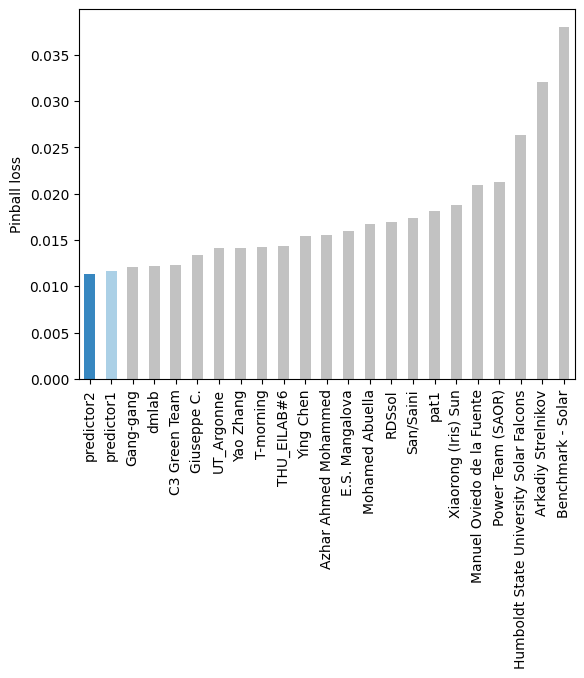

In [10]:
env.plot_overall_results(losses, 
                         drop_tasks=["Task1", "Task2", "Task3", "Task4"]);

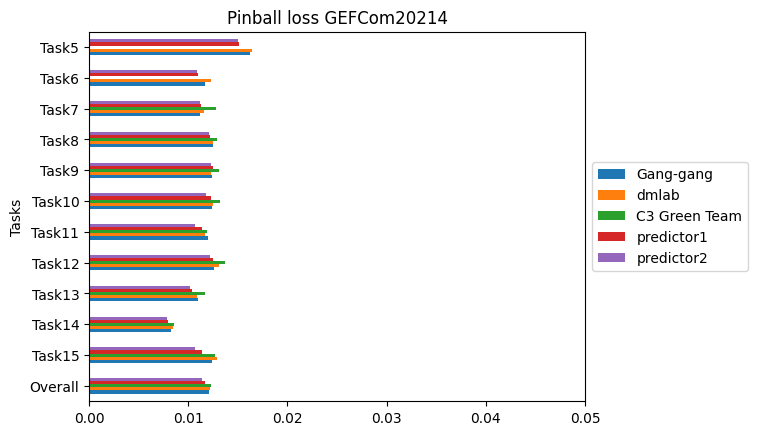

In [13]:
env.plot_results(losses, 
                 drop_tasks=["Task1", "Task2", "Task3", "Task4"], 
                 n_top_teams=3,
                 xlim=0.05);

In [12]:
df_predictions = pd.concat(predictions)
env.plot_forecasts(training_target, df_predictions, site="Site1")